<a href="https://colab.research.google.com/github/ZitongZhou/react_inverse/blob/master/react_trans_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pytorch model for the reaction eqn 6*41*81 contaminant flow prediction

In [1]:
import pickle as pk
import numpy as np
from matplotlib import ticker, cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import json
import argparse
%matplotlib inline
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, MultiStepLR
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
from torchsummary import summary
from google.colab import files
from time import time
from time import sleep
from IPython.display import clear_output
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def simple_plot(c_map, title=''):
    nx = 81
    ny = 41
    Lx = 2500
    Ly = 1250

    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    X,Y = np.meshgrid(x, y)
    if len(c_map) == 41:
        fig, axs = plt.subplots(1,1)
        # axs.set_xlabel('x(m)')
        # axs.set_ylabel('y(m)')
        # axs.set_xlim(0,Lx)
        # axs.set_ylim(0,Ly)
        c01map = axs.imshow(c_map, cmap='jet',
                  extent=[x.min(), x.max(), y.min(), y.max()],
                  vmin=c_map.min(), vmax = c_map.max(),
                  origin='lower')
        fig.colorbar(c01map, ax=axs,shrink=0.62)
    else:
        fig, axs = plt.subplots(len(c_map)//3, 3, figsize=(7, 2.5))
        axs = axs.flat
        for i, ax in enumerate(axs):
            # ax.set_xlim(0,Lx)
            # ax.set_ylim(0,Ly)
            c01map = ax.imshow(c_map[i], cmap='jet', interpolation='nearest',
                      extent=[x.min(), x.max(), y.min(), y.max()],
                      vmin=c_map[i].min(), vmax = c_map[i].max(),
                      origin='lower')
            ax.set_axis_off()
            v1 = np.linspace(np.min(c_map[i]),np.max(c_map[i]), 5, endpoint=True)
            fig.colorbar(c01map, ax=ax, fraction=0.021, pad=0.04,ticks=v1,)

    plt.suptitle(title)
    name = title + '.pdf'
    plt.tight_layout()
    fig.savefig(name, format='pdf',bbox_inches='tight')
    plt.show()
    return

## load the training data, network testing and plotting functions

In [3]:
with h5py.File('/content/drive/MyDrive/react_inverse/training_data/AR_dataset_500.hdf5', 'r') as file:
    AR_input = np.asarray(file['input'])
    AR_output = np.asarray(file['output'])
print('input shape: ',AR_input.shape, '\noutput shape: ', AR_output.shape)

input shape:  (5000, 3, 6, 41, 81) 
output shape:  (5000, 2, 6, 41, 81)


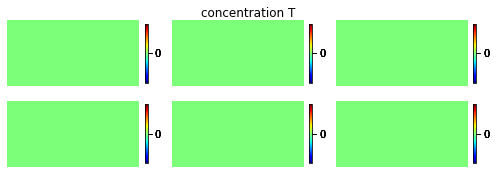

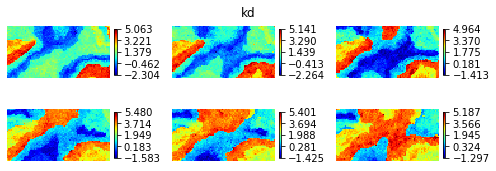

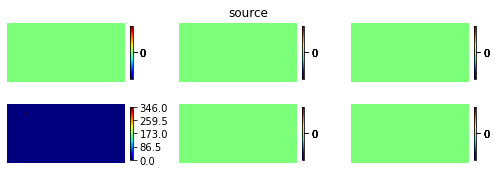

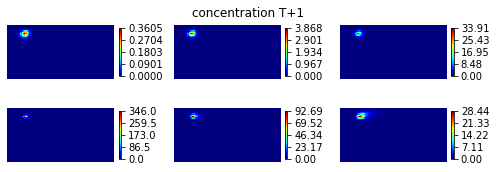

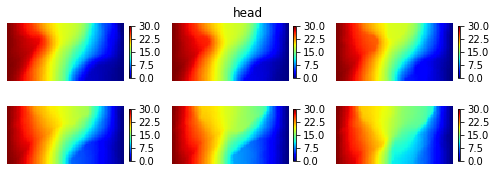

In [13]:
# np.random.seed(8)
# ind = np.random.randint(0, len(AR_input), 2)
ind = [0]
for i in ind:
    input = AR_input[i].copy()
    output = AR_output[i].copy()
    simple_plot(input[0], 'concentration T')
    simple_plot(input[1], 'kd')
    simple_plot(input[2], 'source')
    simple_plot(output[0], 'concentration T+1')
    simple_plot(output[1], 'head')

In [4]:

def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.cpu().detach().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or '\
            'np.ndarray, but got {}'.format(type(input)))


def cal_R2():
    "compute the test R2 score"
    n_test = args.n_test
    y_sum = np.full( (2, 6, 41,81), 0.0)

    for i in range(n_test):
        y_sum = y_sum + y_test[i]
    y_mean = y_sum / n_test

    nominator = 0.0
    denominator = 0.0
    for i in range(n_test):
        x = x_test[i]
        y = np.full( (ntimes + 1,6,41,81), 0.0)
        
        y[:ntimes] = torch.reshape(
            y_test[i * ntimes: (i+1) * ntimes,[0]],
            (10, 6, 41, 81),
        )
        y[ntimes] = y_test[ i * ntimes,[1] ] # head

        y_output = np.full( (ntimes + 1, 6,41,81), 0.0)
        x_ii = np.full((1,x_test.shape[1], 6, 41,81), 0.0)
        y_ii_1 = np.full((6, 41, 81), 0.0)     # y_0 = 0
        for ii in range(ntimes):
            x_ii[0,0,:,:,:] = x[ii,0,:,:,:]   # hydraulic conductivity
            x_ii[0,1,:,:,:] = x[ii,1,:,:,:]   # source rate
            x_ii[0,2,:,:,:] = y_ii_1        # initial conc, start with 0
            x_ii_tensor = (torch.FloatTensor(x_ii)).to(device)
            model.eval()
            with torch.no_grad():
                y_hat = model(x_ii_tensor) #[1, 2, 6, 41, 81]
            y_hat = y_hat.data.cpu().numpy()
            y_output[ii] = y_hat[0,0] #[6, 41, 81], conc
            if ii == ntimes - 1:
                y_output[ii+1] = y_hat[0,1] #[6, 41, 81] head
            y_ii_1 = y_hat[0,0,:,:,:] #set the conc at t to be initial conc at t+1
        nominator = nominator + ((y - y_output)**2).sum()
        denominator = denominator + ((y - y_mean)**2).sum()

    R2 = 1 - nominator/denominator
    print("R2: {}".format(R2))
    return R2

# find the maximum absolute prediction error at Nt concentration fields in each test sample,
# i.e., the results shown in Figure 13 of the paper
def max_err():
    n_test = args.n_test
    ErrMax = np.zeros((n_test*Nt))
    for i in range(n_test):
        x = x_test[ i * ntimes: (i+1) * ntimes - 2]
        y = np.full( (Nt,1,41,81), 0.0)
        y[:Nt] = y_test[i * ntimes: (i+1) * ntimes - 2,[0]] # concentration at n_t time instances

        y_output = np.full( (Nt, 1,41,81), 0.0)
        x_ii = np.full((1,x_test.shape[1],41,81), 0.0)
        y_ii_1 = np.full((41,81), 0.0)     # y_0 = 0
        for ii in range(Nt):
            x_ii[0,0,:,:] = x[ii,0,:,:]   # hydraulic conductivity
            x_ii[0,1,:,:] = x[ii,1,:,:]   # source rate
            x_ii[0,2,:,:] = y_ii_1        # the ii_th predicted output
            x_ii_tensor = (torch.FloatTensor(x_ii)).to(device)
            model.eval()
            with torch.no_grad():
                y_hat = model(x_ii_tensor)
            y_hat = y_hat.data.cpu().numpy()
            y_output[ii,0] = y_hat[0,0]
            y_ii_1 = y_hat[0,0,:,:]
        err = np.abs(y - y_output)

        ErrMax[i*Nt : (i+1)*Nt] = ( ( err.max(axis=1) ).max(axis=1) ).max(axis=1)

    np.savetxt(exp_dir +'/TestErrMax_ntrain{}.dat'.format(args.n_train), ErrMax, fmt='%10.4f')   # use exponential notation
    return None

In [5]:
def save_stats(save_dir, logger, x_axis):

    rmse_train = logger['rmse_train']
    rmse_test = logger['rmse_test']
    r2_train = logger['r2_train']
    r2_test = logger['r2_test']

    if 'mnlp_test' in logger.keys():
        mnlp_test = logger['mnlp_test']
        if len(mnlp_test) > 0:
            plt.figure()
            plt.plot(x_axis, mnlp_test, label="Test: {:.3f}".format(np.mean(mnlp_test[-5:])))
            plt.xlabel('Epoch')
            plt.ylabel('MNLP')
            plt.legend(loc='upper right')
            plt.savefig(save_dir + "/mnlp_test.pdf", dpi=600)
            plt.close()
            np.savetxt(save_dir + "/mnlp_test.txt", mnlp_test)
    
    if 'log_beta' in logger.keys():
        log_beta = logger['log_beta']
        if len(log_beta) > 0:
            plt.figure()
            plt.plot(x_axis, log_beta, label="Test: {:.3f}".format(np.mean(log_beta[-5:])))
            plt.xlabel('Epoch')
            plt.ylabel('Log-Beta (noise precision)')
            plt.legend(loc='upper right')
            plt.savefig(save_dir + "/log_beta.pdf", dpi=600)
            plt.close()
            np.savetxt(save_dir + "/log_beta.txt", log_beta)

    plt.figure()
    plt.plot(x_axis, r2_train, label="Train: {:.3f}".format(np.mean(r2_train[-5:])))
    plt.plot(x_axis, r2_test, label="Test: {:.3f}".format(np.mean(r2_test[-5:])))
    plt.xlabel('Epoch')
    plt.ylabel(r'$R^2$-score')
    plt.legend(loc='lower right')
    plt.savefig(save_dir + "/r2.pdf", dpi=600)
    plt.close()
    np.savetxt(save_dir + "/r2_train.txt", r2_train)
    np.savetxt(save_dir + "/r2_test.txt", r2_test)

    plt.figure()
    plt.plot(x_axis, rmse_train, label="train: {:.3f}".format(np.mean(rmse_train[-5:])))
    plt.plot(x_axis, rmse_test, label="test: {:.3f}".format(np.mean(rmse_test[-5:])))
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend(loc='upper right')
    plt.savefig(save_dir + "/rmse.pdf", dpi=600)
    plt.close()
    np.savetxt(save_dir + "/rmse_train.txt", rmse_train)
    np.savetxt(save_dir + "/rmse_test.txt", rmse_test)
    
def plot_prediction_bayes(save_dir, target, output, epoch, index_simu):
    """Plot predictions at *one* test input

    Args:
        save_dir: directory to save predictions
        target (np.ndarray or torch.Tensor): （2， 6， 41， 81）
        output (np.ndarray or torch.Tensor): （2， 6， 41， 81)
        epoch (int): which epoch
        index (int): i-th prediction
    """
    target, output = to_numpy(target), to_numpy(output)
    target = np.reshape(target, (12, 41, 81))
    output = np.reshape(output, (12, 41, 81))
    pred_error = target - output
    # target: C x D x H x W

    fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(11, 5))
    axes = axes.flat
    index = [[i, i+6] for i in range(6)] + [[i, i+6] for i in range(18, 18+6)]
    error_index = list(np.arange(12, 18)) + list(np.arange(30, 36))
    y_ind = 0
    axes_pad = 0.1
    cbar_pad = 0.1
    label_size = 6
    for ind_pair in index:
        axy = axes[ind_pair[0]]
        data = [target[y_ind], output[y_ind]]
        vmin = np.min(data)
        vmax = np.max(data)
        imy = axy.imshow(data[0], vmin=vmin, vmax=vmax, cmap = 'jet')
        axout = axes[ind_pair[1]]
        imout = axout.imshow(data[1], vmin=vmin, vmax=vmax, cmap = 'jet')
        axy.set_axis_off()
        axout.set_axis_off()
        v1 = np.linspace(vmin, vmax, 7, endpoint=True)
        cbar = fig.colorbar(imout, ax=[axes[ind_pair[0]], axes[ind_pair[1]]], 
                            format='%.2f', aspect=20, shrink = 0.95)
        cbar.set_ticks(v1)
        cbar.ax.tick_params(labelsize=label_size)
        y_ind += 1

    e_ind = 0
    for ind_error in error_index:
        axe = axes[ind_error]
        vmax = np.max(np.abs(pred_error[e_ind]))
        vmin = -vmax
        ime = axe.imshow(pred_error[e_ind], vmin=vmin, vmax=vmax, cmap = 'jet')
        axe.set_axis_off()
        v1 = np.linspace(vmin, vmax, 5, endpoint=True)
        cbar = fig.colorbar(ime, ax=axes[ind_error], format='%.2f', aspect=8, shrink = 0.87)
        cbar.set_ticks(v1)
        cbar.ax.tick_params(labelsize=label_size)
        e_ind += 1
        
    plt.savefig(save_dir + '/pred_at_x_epoch{}_{}.pdf'.format(epoch, index_simu), 
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

def test(epoch, plot_intv):
    model.eval()
    loss = 0.
    for batch_idx, (input, target) in enumerate(test_loader):
        input, target = input.to(device), target.to(device)

        with torch.no_grad():
            output = model(input)
        loss += F.mse_loss(output, target, reduction='sum').item()

        # plot predictions
        if epoch % plot_intv == 0 and batch_idx == len(test_loader) - 1:
            n_samples = 2
            idx = torch.LongTensor(np.random.choice(args.n_test, n_samples, replace=False))

            print("Index of data: {}".format(idx))
            print("X shape: {}".format(x_test.shape))

            for i in range(n_samples):
                model.eval()
                _input = torch.tensor(np.expand_dims(x_test[idx[i]], axis=0)).to(device)
                test_output = model(_input)
                test_target = y_test[idx[i]]
                plot_prediction_bayes(output_dir, test_target, test_output, epoch, idx[i])
                print("epoch {}, done with printing sample output {}".format(epoch, idx[i]))

    rmse_test = np.sqrt(loss / n_out_pixels_test)
    r2_score = 1 - loss / test_stats['y_var']
    print("epoch: {}, test r2-score:  {:.4f}".format(epoch, r2_score))
    return r2_score, rmse_test

# Dense ED 3D with autoregressive dataset

## Dense ED 3d block

In [ ]:
"""
Convolutional Dense Encoder-Decoder Networks

Reference:
    https://github.com/pytorch/vision/blob/master/torchvision/models/densenet.py

Yinhao Zhu
Dec 21, 2017
Dec 30, 2017
Jan 03, 2018

Shaoxing Mo
May 07, 2019

Zitong Zhou
Feb 18, 2021
"""


class _DenseLayer(nn.Sequential):
    # bottleneck layer, bn_size: bottleneck size
    def __init__(self, in_features, growth_rate, drop_rate=0, bn_size=4,
                 bottleneck=False):
        # detect if the input features are more than bn_size x k,
        # if yes, use bottleneck -- not much memory gain, but lose one relu
        # I disabled the bottleneck for current implementation
        super(_DenseLayer, self).__init__()
        if bottleneck and in_features > bn_size * growth_rate:
            self.add_module('norm1', nn.BatchNorm3d(in_features))
            self.add_module('relu1', nn.ReLU(inplace=True))
            self.add_module('conv1', nn.Conv3d(in_features, bn_size *
                            growth_rate, kernel_size=1, stride=1, bias=False))
            self.add_module('norm2', nn.BatchNorm3d(bn_size * growth_rate))
            self.add_module('relu2', nn.ReLU(inplace=True))
            self.add_module('conv2', nn.Conv3d(bn_size * growth_rate, growth_rate,
                            kernel_size=3, stride=1, padding=1, bias=False))
        else:
            self.add_module('norm1', nn.BatchNorm3d(in_features))
            self.add_module('relu1', nn.ReLU(inplace=True))
            self.add_module('conv1', nn.Conv3d(in_features, growth_rate,
                            kernel_size=3, stride=1, padding=1, bias=False))
        self.drop_rate = drop_rate

    def forward(self, x):
        y = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            y = F.dropout3d(y, p=self.drop_rate, training=self.training)
        z = torch.cat([x, y], 1)
        return z


class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, in_features, growth_rate, drop_rate,
                 bn_size=4, bottleneck=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(in_features + i * growth_rate, growth_rate,
                                drop_rate=drop_rate, bn_size=bn_size,
                                bottleneck=bottleneck)
            self.add_module('denselayer%d' % (i + 1), layer)

class _Transition(nn.Sequential):
    def __init__(self, in_features, out_features, encoding=True, drop_rate=0.,
                 last=False, out_channels=3, outsize_even=True):
        super(_Transition, self).__init__()
        self.add_module('norm1', nn.BatchNorm3d(in_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        if encoding:
            # reduce feature maps; half image size (input feature size is even)
            # bottleneck impl, save memory, add nonlinearity
            self.add_module('conv1', nn.Conv3d(in_features, out_features,
                                              kernel_size=1, stride=1,
                                              padding=0, bias=False))
            if drop_rate > 0:
                self.add_module('dropout1', nn.Dropout3d(p=drop_rate))
            self.add_module('norm2', nn.BatchNorm3d(out_features))
            self.add_module('relu2', nn.ReLU(inplace=True))
            self.add_module('conv2', nn.Conv3d(out_features, out_features,
                                              kernel_size=3, stride=2,
                                              padding=1, bias=False))
            if drop_rate > 0:
                self.add_module('dropout2', nn.Dropout3d(p=drop_rate))
        else:
            # decoding, transition up
            if last:
                ks = 6 if outsize_even else 5
                out_convt = nn.ConvTranspose3d(out_features, out_channels,
                                kernel_size=[2,ks,ks], stride=2, padding=[0,2,2],
                                output_padding=[0,0,0], bias=False)
            else:
                out_convt = nn.ConvTranspose3d(
                    out_features, out_features, kernel_size=3, stride=2,
                    padding=1, output_padding=0, bias=False)

            # bottleneck impl, save memory, add nonlinearity
            self.add_module('conv1', nn.Conv3d(in_features, out_features,
                                              kernel_size=1, stride=1,
                                              padding=0, bias=False))
            if drop_rate > 0:
                self.add_module('dropout1', nn.Dropout3d(p=drop_rate))

            self.add_module('norm2', nn.BatchNorm3d(out_features))
            self.add_module('relu2', nn.ReLU(inplace=True))
            self.add_module('convT2', out_convt)
            if drop_rate > 0:
                self.add_module('dropout2', nn.Dropout3d(p=drop_rate))

class DenseED(nn.Module):
    def __init__(self, in_channels, out_channels, blocks, growth_rate=16,
                 num_init_features=64, bn_size=4, drop_rate=0, outsize_even=False,
                 bottleneck=False):
        """
        Args:
            in_channels (int): number of input channels
            out_channels (int): number of output channels
            blocks: list (of odd size) of integers
            growth_rate (int): K
            num_init_features (int): the number of feature maps after the first
                conv layer
            bn_size: bottleneck size for number of feature maps (not useful...)
            bottleneck (bool): use bottleneck for dense block or not
            drop_rate (float): dropout rate
            outsize_even (bool): if the output size is even or odd (e.g.
                65 x 65 is odd, 64 x 64 is even)

        """
        super(DenseED, self).__init__()
        self.out_channels = out_channels

        if len(blocks) > 1 and len(blocks) % 2 == 0:
            ValueError('length of blocks must be an odd number, but got {}'
                       .format(len(blocks)))
        enc_block_layers = blocks[: len(blocks) // 2]
        dec_block_layers = blocks[len(blocks) // 2:]
        self.features = nn.Sequential()
        # First convolution ================
        # only conv, half image size
        self.features.add_module('in_conv',
                    nn.Conv3d(in_channels, num_init_features,
                            kernel_size=[3,7,7], stride=2, padding=[1,3,3], bias=False))

        # Encoding / transition down ================
        # dense block --> encoding --> dense block --> encoding
        num_features = num_init_features
        for i, num_layers in enumerate(enc_block_layers):
            block = _DenseBlock(num_layers=num_layers,
                                in_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate,
                                drop_rate=drop_rate, bottleneck=bottleneck)
            self.features.add_module('encblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate

            trans = _Transition(in_features=num_features,
                                out_features=num_features // 2,
                                encoding=True, drop_rate=drop_rate)
            self.features.add_module('down%d' % (i + 1), trans)
            num_features = num_features // 2

        # Decoding / transition up ==============
        # dense block --> decoding --> dense block --> decoding --> dense block
        # if len(dec_block_layers) - len(enc_block_layers) == 1:
        for i, num_layers in enumerate(dec_block_layers):
            block = _DenseBlock(num_layers=num_layers,
                                in_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate,
                                drop_rate=drop_rate, bottleneck=bottleneck)
            self.features.add_module('decblock%d' % (i + 1), block)
            num_features += num_layers * growth_rate

            # if this is the last decoding layer is the output layer
            last_layer = True if i == len(dec_block_layers) - 1 else False

            trans = _Transition(in_features=num_features,
                                out_features=num_features // 2,
                                encoding=False, drop_rate=drop_rate,
                                last=last_layer, out_channels=out_channels,
                                outsize_even=outsize_even)
            self.features.add_module('up%d' % (i + 1), trans)
            num_features = num_features // 2

    def forward(self, x):
        y = self.features(x)

        # use the softplus activation for concentration and head
        y = F.softplus(y.clone(), beta=5)

        # CAUTION: if the last channel is pressure, 
        # use the sigmoid activation for pressure
        # y[:,self.out_channels-1] = torch.sigmoid(y[:,self.out_channels-1])

        return y

    def _num_parameters_convlayers(self):
        n_params, n_conv_layers = 0, 0
        for name, param in self.named_parameters():
            if 'conv' in name:
                n_conv_layers += 1
            n_params += param.numel()
        return n_params, n_conv_layers

    def _count_parameters(self):
        n_params = 0
        for name, param in self.named_parameters():
            print(name)
            print(param.size())
            print(param.numel())
            n_params += param.numel()
            print('num of parameters so far: {}'.format(n_params))

    def reset_parameters(self, verbose=False):
        for module in self.modules():
            # pass self, otherwise infinite loop
            if isinstance(module, self.__class__):
                continue
            if 'reset_parameters' in dir(module):
                if callable(module.reset_parameters):
                    module.reset_parameters()
                    if verbose:
                        print("Reset parameters in {}".format(module))


## Set training arguments, loss function, testing, etc

In [ ]:
parser = argparse.ArgumentParser(description='Dnense Encoder-Decoder Convolutional Network')
parser.add_argument('-f')
parser.add_argument('--exp-name', type=str, default='AR-Net-WL', help='experiment name')
parser.add_argument('--blocks', type=list, default=(5, 10, 5), help='list of number of layers in each block in decoding net')
parser.add_argument('--growth-rate', type=int, default=40, help='output of each conv')
parser.add_argument('--drop-rate', type=float, default=0, help='dropout rate')
parser.add_argument('--bn-size', type=int, default=8, help='bottleneck size: bn_size * growth_rate')
parser.add_argument('--bottleneck', action='store_true', default=False, help='enable bottleneck in the dense blocks')
parser.add_argument('--init-features', type=int, default=48, help='# initial features after the first conv layer')

parser.add_argument('--data-dir', type=str, default="/content/drive/MyDrive/react_inverse/dense_ed_3d/", help='data directory')
parser.add_argument('--n-train', type=int, default=1000, help="number of training data")
parser.add_argument('--n-test', type=int, default=500, help="number of test data")

parser.add_argument('--w-c', type=float, default=5.0, help='weight value in the weighted loss')
parser.add_argument('--n-epochs', type=int, default=300, help='number of epochs to train (default: 200)')
parser.add_argument('--lr', type=float, default=0.005, help='learnign rate')
parser.add_argument('--weight-decay', type=float, default=5e-5, help="weight decay")
parser.add_argument('--batch-size', type=int, default=32, help='input batch size for training (default: 100)')
parser.add_argument('--test-batch-size', type=int, default=64, help='input batch size for testing (default: 100)')
parser.add_argument('--log-interval', type=int, default=50, help='how many epochs to wait before logging training status')
parser.add_argument('--plot-interval', type=int, default=50, help='how many epochs to wait before plotting training status')

args = parser.parse_args()

In [ ]:
all_over_again = 'Mar_15'

exp_dir = args.data_dir + all_over_again + "/{}/Ntrs{}__Bks{}_Bts{}_Eps{}_wd{}_lr{}_K{}_w_c{}".\
    format(args.exp_name, args.n_train,args.blocks,
           args.batch_size, args.n_epochs, args.weight_decay, args.lr, args.growth_rate,args.w_c)

output_dir = exp_dir + "/predictions"
model_dir = exp_dir
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


ntimes = 10  # ntimes is the total number of time instances considered
Nt = 5      # Nt is the number of time instances with non-zero source rate

In [ ]:
x_train = AR_input[:args.n_train]
x_test = AR_input[args.n_train: args.n_train+args.n_test]
y_train = AR_output[:args.n_train]
y_test = AR_output[args.n_train: args.n_train+args.n_test]
y_train_mean = np.mean(y_train, 0)
y_train_var = np.sum((y_train - y_train_mean) ** 2)
print('y_train_var: {}'.format(y_train_var))
train_stats = {}
train_stats['y_mean'] = y_train_mean
train_stats['y_var'] = y_train_var

y_test_mean = np.mean(y_test, 0)
y_test_var = np.sum((y_test - y_test_mean) ** 2)
print('y_test_var: {}'.format(y_test_var))
test_stats = {}
test_stats['y_mean'] = y_test_mean
test_stats['y_var'] = y_test_var

data_train = utils.TensorDataset(torch.FloatTensor(x_train),
                                 torch.FloatTensor(y_train))
data_test = utils.TensorDataset(torch.FloatTensor(x_test),
                                torch.FloatTensor(y_test))
kwargs = {'num_workers': 4,
          'pin_memory': True} if torch.cuda.is_available() else {}
train_loader = DataLoader(data_train,
                          batch_size=args.batch_size,
                          shuffle=True, **kwargs)

test_loader = DataLoader(data_test,
                         batch_size=args.test_batch_size,
                         shuffle=True, **kwargs)

y_train_var: 1218055040.0
y_test_var: 675587072.0


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseED(x_train.shape[1], y_train.shape[1], blocks=args.blocks, growth_rate=args.growth_rate,
                drop_rate=args.drop_rate, bn_size=args.bn_size,
                num_init_features=args.init_features, bottleneck=args.bottleneck).to(device)

print("number of parameters: {}\nnumber of layers: {}"
              .format(*model._num_parameters_convlayers()))

optimizer = optim.Adam(model.parameters(), lr=args.lr,
                       weight_decay=args.weight_decay)

scheduler = ReduceLROnPlateau(
                    optimizer, mode='min', factor=0.1, patience=10,
                    verbose=True, threshold=0.0001, threshold_mode='rel',
                    cooldown=0, min_lr=0, eps=1e-08)

n_out_pixels_train = len(train_loader.dataset) * train_loader.dataset[0][1].numel()
n_out_pixels_test = len(test_loader.dataset) * test_loader.dataset[0][1].numel()


number of parameters: 8423252
number of layers: 27


In [ ]:
# print(model)
# summary(model,x_train[0].shape)

epoch: 50, training r2-score: 0.818195
Index of data: tensor([ 87, 160])
X shape: (500, 3, 6, 41, 81)


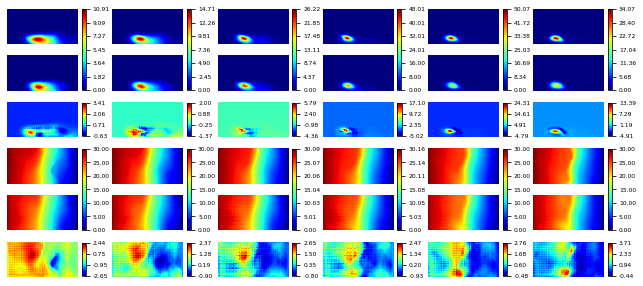

epoch 50, done with printing sample output 87


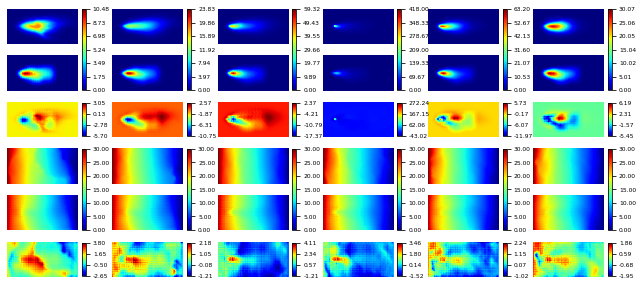

epoch 50, done with printing sample output 160
epoch: 50, test r2-score:  0.7945
loss: 230521.296875
epoch: 100, training r2-score: 0.879698
Index of data: tensor([200, 186])
X shape: (500, 3, 6, 41, 81)


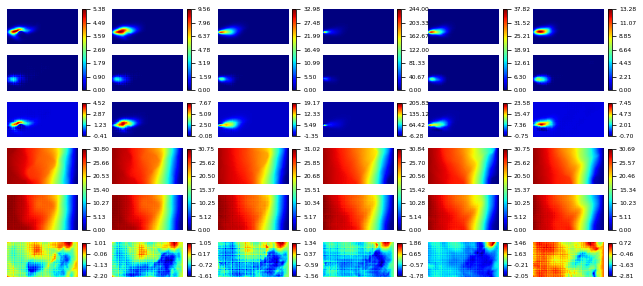

epoch 100, done with printing sample output 200


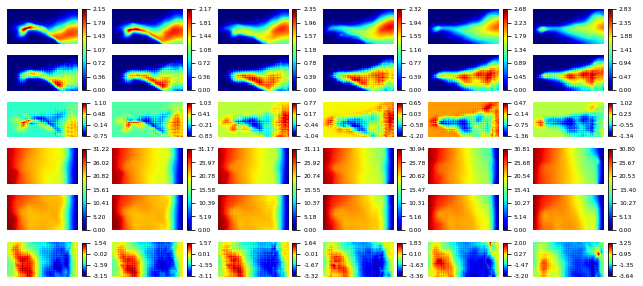

epoch 100, done with printing sample output 186
epoch: 100, test r2-score:  0.8213
loss: 128897.5546875
Epoch   111: reducing learning rate of group 0 to 5.0000e-04.
Epoch   130: reducing learning rate of group 0 to 5.0000e-05.
epoch: 150, training r2-score: 0.894404
Index of data: tensor([213, 169])
X shape: (500, 3, 6, 41, 81)


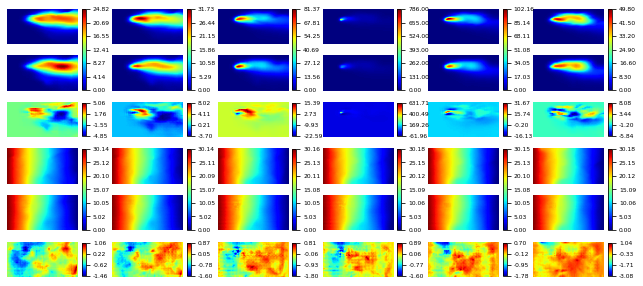

epoch 150, done with printing sample output 213


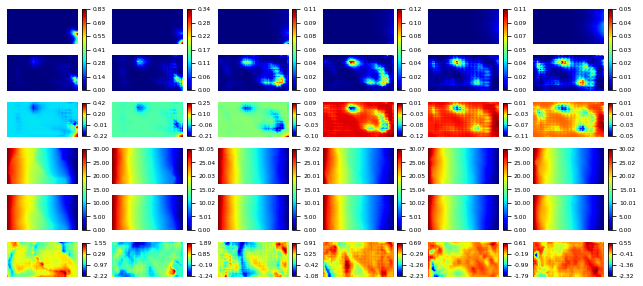

epoch 150, done with printing sample output 169
epoch: 150, test r2-score:  0.8446
loss: 84605.6328125
Epoch   169: reducing learning rate of group 0 to 5.0000e-06.
Epoch   180: reducing learning rate of group 0 to 5.0000e-07.
epoch: 200, training r2-score: 0.897576
Index of data: tensor([177, 330])
X shape: (500, 3, 6, 41, 81)


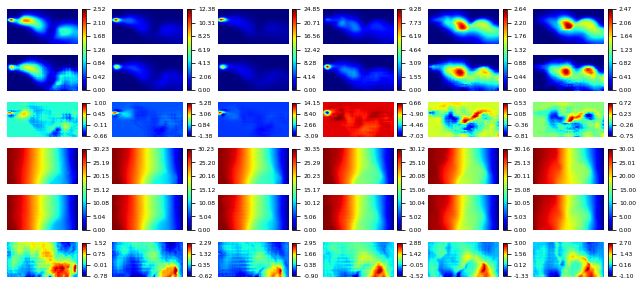

epoch 200, done with printing sample output 177


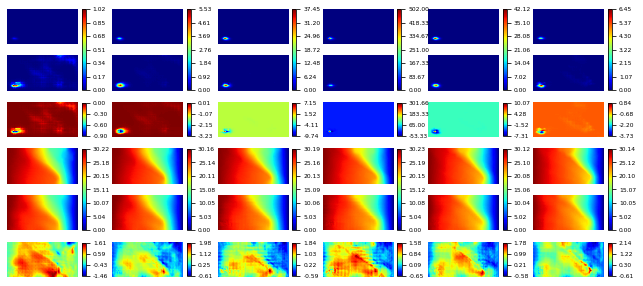

epoch 200, done with printing sample output 330
epoch: 200, test r2-score:  0.8441
loss: 71940.984375
Epoch   200: reducing learning rate of group 0 to 5.0000e-08.
Epoch   211: reducing learning rate of group 0 to 5.0000e-09.
epoch: 250, training r2-score: 0.897344
Index of data: tensor([431, 332])
X shape: (500, 3, 6, 41, 81)


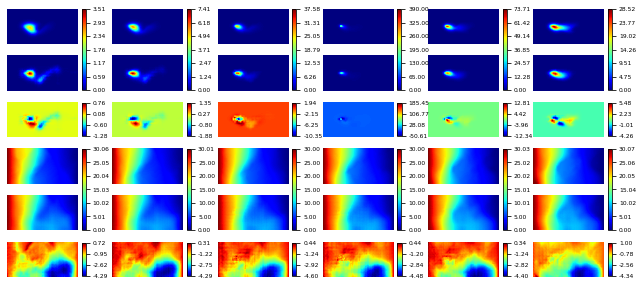

epoch 250, done with printing sample output 431


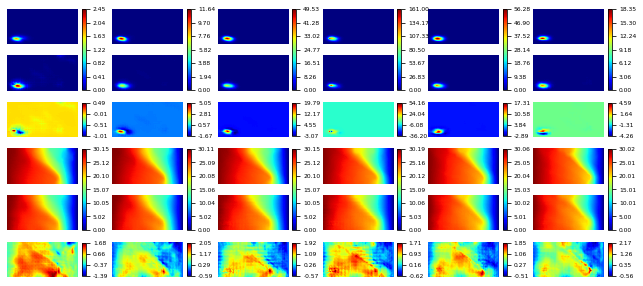

epoch 250, done with printing sample output 332
epoch: 250, test r2-score:  0.8456
loss: 81006.6640625
epoch: 300, training r2-score: 0.897018
Index of data: tensor([452, 423])
X shape: (500, 3, 6, 41, 81)


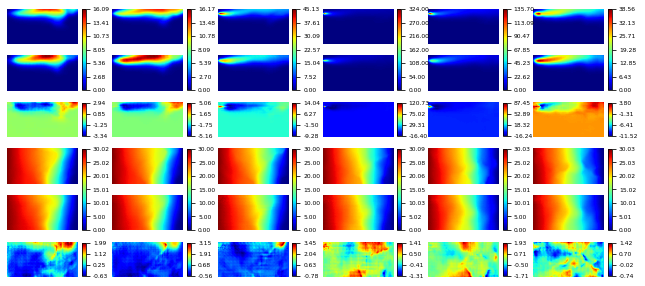

epoch 300, done with printing sample output 452


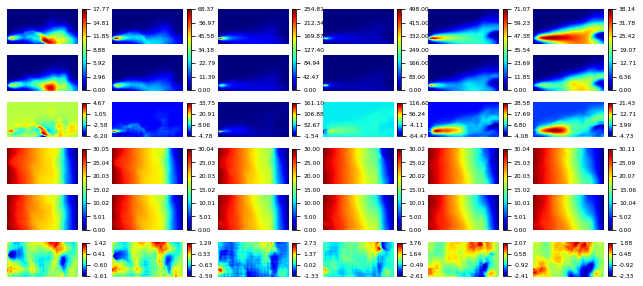

epoch 300, done with printing sample output 423
epoch: 300, test r2-score:  0.8369
loss: 87279.796875
Done training 300 epochs with 1000 data using 3549.695327281952 seconds


In [ ]:
logger = {}
logger['rmse_train'] = []
logger['rmse_test'] = []
logger['r2_train'] = []
logger['r2_test'] = []

tic = time()
R2_test_self = []
r2_train, r2_test = [], []
rmse_train, rmse_test = [], []
for epoch in range(1, args.n_epochs + 1):
    # train
    model.train()
    mse = 0.
    for batch_idx, (input, target) in enumerate(train_loader):
        input, target= input.to(device), target.to(device)
        model.zero_grad()
        output = model(input)

        loss = F.l1_loss(output, target, reduction='sum')

        # for computing the RMSE criterion solely
        loss_mse = F.mse_loss(output, target, reduction='sum')

        loss.backward()
        optimizer.step()
        mse += loss_mse.item()

    rmse = np.sqrt(mse / n_out_pixels_train)
    if epoch % args.log_interval == 0:
        r2_score = 1 - mse / train_stats['y_var']
        print("epoch: {}, training r2-score: {:.6f}".format(epoch, r2_score))
        r2_train.append(r2_score)
        rmse_train.append(rmse)
        r2_t, rmse_t = test(epoch, plot_intv=args.plot_interval)
        r2_test.append(r2_t)
        rmse_test.append(rmse_t)
        print("loss: {}".format(loss))

    scheduler.step(rmse)

    # save model
    if epoch == args.n_epochs:
        torch.save(model.state_dict(), model_dir + "/model_epoch{}.pth".format(epoch))
tic2 = time()
print("Done training {} epochs with {} data using {} seconds"
      .format(args.n_epochs, args.n_train, tic2 - tic))

x = np.arange(args.log_interval, args.n_epochs + args.log_interval,
                args.log_interval)
plt.figure()
plt.plot(x, r2_train, 'k', label="train: {:.3f}".format(np.mean(r2_train[-5: -1])))
plt.plot(x, r2_test, 'r', linestyle = '--', label="test: {:.3f}".format(np.mean(r2_test[-5: -1])))
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('$R^2$', fontsize=14)
plt.legend(loc='lower right')
plt.savefig(exp_dir + "/r2.png", dpi=400)
plt.close()
np.savetxt(exp_dir + "/r2_train.txt", r2_train)
np.savetxt(exp_dir + "/r2_test.txt", r2_test)

plt.figure()
plt.plot(x, rmse_train, 'k', label="train: {:.3f}".format(np.mean(rmse_train[-5: -1])))
plt.plot(x, rmse_test, 'r', linestyle = '--', label="test: {:.3f}".format(np.mean(rmse_test[-5: -1])))
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.legend(loc='upper right')
plt.savefig(exp_dir + "/rmse.png", dpi=400)
plt.close()
np.savetxt(exp_dir + "/rmse_train.txt", rmse_train)
np.savetxt(exp_dir + "/rmse_test.txt", rmse_test)

# save args and time taken
args_dict = {}
for arg in vars(args):
    args_dict[arg] = getattr(args, arg)
args_dict['time'] = tic2 - tic
n_params, n_layers = model._num_parameters_convlayers()
args_dict['num_layers'] = n_layers
args_dict['num_params'] = n_params
with open(exp_dir + "/args.txt", 'w') as file:
    file.write(json.dumps(args_dict))

# R2_test_s = cal_R2()
# R2_test_self.append(R2_test_s)
# np.savetxt(exp_dir + "/R2_test_self.txt", R2_test_self)

In [ ]:
np.savetxt(exp_dir + "/training_time.txt", [tic2 - tic])

# DRDCN 3D

In [6]:


class mish(nn.Module):
    '''
    Applies the mish function element-wise:
    mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + exp(x)))
    See additional documentation for mish class.
    '''
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * torch.tanh(F.softplus(x))


class DenseResidualBlock(nn.Module):
    """
    The core module of paper: (Residual Dense Network for Image Super-Resolution, CVPR 18)
    """

    def __init__(self, filters, res_scale=0.2):
        super(DenseResidualBlock, self).__init__()
        self.res_scale = res_scale

        def block(in_features, non_linearity=True):
            layers = [nn.BatchNorm3d(in_features)]
            layers += [mish()]
            layers += [nn.Conv3d(in_features, filters, 3, 1, 1, bias=True)]
            return nn.Sequential(*layers)

        self.b1 = block(in_features=1 * filters)
        self.b2 = block(in_features=2 * filters)
        self.b3 = block(in_features=3 * filters)
        self.b4 = block(in_features=4 * filters)
        self.b5 = block(in_features=5 * filters)
        self.blocks = [self.b1, self.b2, self.b3, self.b4, self.b5]

    def forward(self, x):
        inputs = x
        for block in self.blocks:
            out = block(inputs)
            inputs = torch.cat([inputs, out], 1)
        return out.mul(self.res_scale) + x
        # return out + x


class ResidualInResidualDenseBlock(nn.Module):
    def __init__(self, filters, res_scale=0.2):
        super(ResidualInResidualDenseBlock, self).__init__()
        self.res_scale = res_scale
        self.dense_blocks = nn.Sequential(
            DenseResidualBlock(filters), DenseResidualBlock(filters), DenseResidualBlock(filters)#, DenseResidualBlock(filters)
        )

    def forward(self, x):
        return self.dense_blocks(x).mul(self.res_scale) + x
        # return self.dense_blocks(x) + x


class RRDB(nn.Module):
    def __init__(self, in_channels, out_channels, filters=48, num_res_blocks=1):
        super(RRDB, self).__init__()
        self.out_channels = out_channels

        # encoder
        # First layer
        self.conv1 = nn.Conv3d(in_channels, filters, kernel_size=3, stride=2, padding=1)
        self.res_blocks_e = nn.Sequential(*[ResidualInResidualDenseBlock(filters) for _ in range(num_res_blocks+0)])

        self.transdown = nn.Sequential(
            nn.BatchNorm3d(filters),
            mish(),
            nn.Conv3d(filters, filters, kernel_size=3, stride=2, padding=1),
        )

        # Residual blocks
        self.res_blocks_c = nn.Sequential(*[ResidualInResidualDenseBlock(filters) for _ in range(num_res_blocks+1)])

        # decoder
        self.transup1 = nn.Sequential(
            nn.BatchNorm3d(filters),
            mish(),
            nn.Upsample(size=[3, 21, 41], mode='nearest'),
            nn.Conv3d(filters, filters, kernel_size=3, stride=1, padding=1),
        )

        self.res_blocks_d = nn.Sequential(*[ResidualInResidualDenseBlock(filters) for _ in range(num_res_blocks+0)])
        self.transup2 = nn.Sequential(
            nn.BatchNorm3d(filters),
            mish(),
            nn.Upsample(size=[6, 41, 81], mode='nearest'),
            nn.Conv3d(filters, out_channels, kernel_size=3, stride=1, padding=1,
        )
        )

    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.res_blocks_e(out1)
        out3 = self.transdown(out2)

        out4 = self.res_blocks_c(out3)
        out = torch.add(out3, out4)
        out5 = self.transup1(out)
        out6 = self.res_blocks_d(out5)
        out = self.transup2(out6)

        # softplus activation for the concentrations
        out = F.softplus(out.clone(), beta=5)

        return out

    def _num_parameters_convlayers(self):
        n_params, n_conv_layers = 0, 0
        for name, param in self.named_parameters():
            if 'conv' in name:
                n_conv_layers += 1
            n_params += param.numel()
        return n_params, n_conv_layers

    def _count_parameters(self):
        n_params = 0
        for name, param in self.named_parameters():
            print(name)
            print(param.size())
            print(param.numel())
            n_params += param.numel()
            print('num of parameters so far: {}'.format(n_params))


def plot_r2_rmse(r2_train, r2_test, rmse_train, rmse_test, exp_dir, args):
    x = np.arange(args.log_interval, args.n_epochs + args.log_interval,
                args.log_interval)
    plt.figure()
    plt.plot(x, r2_train, 'k', label="train: {:.3f}".format(np.mean(r2_train[-5: -1])))
    plt.plot(x, r2_test, 'r', linestyle = '--', label="test: {:.3f}".format(np.mean(r2_test[-5: -1])))
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('$R^2$', fontsize=14)
    plt.legend(loc='lower right')
    plt.savefig(exp_dir + "/r2.png", dpi=400)
    plt.close()
    np.savetxt(exp_dir + "/r2_train.txt", r2_train)
    np.savetxt(exp_dir + "/r2_test.txt", r2_test)

    plt.figure()
    plt.plot(x, rmse_train, 'k', label="train: {:.3f}".format(np.mean(rmse_train[-5: -1])))
    plt.plot(x, rmse_test, 'r', linestyle = '--', label="test: {:.3f}".format(np.mean(rmse_test[-5: -1])))
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('RMSE', fontsize=14)
    plt.legend(loc='upper right')
    plt.savefig(exp_dir + "/rmse.png", dpi=400)
    plt.close()
    np.savetxt(exp_dir + "/rmse_train.txt", rmse_train)
    np.savetxt(exp_dir + "/rmse_test.txt", rmse_test)

In [7]:
parser = argparse.ArgumentParser(description='DRDCN')
parser.add_argument('-f')
parser.add_argument('--exp-name', type=str, default='DRDCN', help='experiment name')
parser.add_argument('--filters', type=int, default=48, help='# initial features after the first conv layer')
parser.add_argument('--data-dir', type=str, default="/content/drive/MyDrive/react_inverse/DRDCN_det/", help='data directory')

parser.add_argument('--n-train', type=int, default=1000, help="number of training data")
parser.add_argument('--n-test', type=int, default=500, help="number of test data")

parser.add_argument('--n-epochs', type=int, default=500, help='number of epochs to train (default: 200)')
parser.add_argument('--lr', type=float, default=0.01, help='learnign rate')
parser.add_argument('--weight-decay', type=float, default=1e-5, help="weight decay")
parser.add_argument('--batch-size', type=int, default=32, help='input batch size for training (default: 100)')
parser.add_argument('--test-batch-size', type=int, default=64, help='input batch size for testing (default: 100)')
parser.add_argument('--log-interval', type=int, default=50, help='how many epochs to wait before logging training status')
parser.add_argument('--plot-interval', type=int, default=50, help='how many epochs to wait before plotting training status')

args = parser.parse_args()

In [8]:
x_train = AR_input[:args.n_train]
x_test = AR_input[args.n_train: args.n_train+args.n_test]
y_train = AR_output[:args.n_train]
y_test = AR_output[args.n_train: args.n_train+args.n_test]
y_train_mean = np.mean(y_train, 0)
y_train_var = np.sum((y_train - y_train_mean) ** 2)
print('y_train_var: {}'.format(y_train_var))
train_stats = {}
train_stats['y_mean'] = y_train_mean
train_stats['y_var'] = y_train_var

y_test_mean = np.mean(y_test, 0)
y_test_var = np.sum((y_test - y_test_mean) ** 2)
print('y_test_var: {}'.format(y_test_var))
test_stats = {}
test_stats['y_mean'] = y_test_mean
test_stats['y_var'] = y_test_var

data_train = utils.TensorDataset(torch.FloatTensor(x_train),
                                 torch.FloatTensor(y_train))
data_test = utils.TensorDataset(torch.FloatTensor(x_test),
                                torch.FloatTensor(y_test))
kwargs = {'num_workers': 4,
          'pin_memory': True} if torch.cuda.is_available() else {}
train_loader = DataLoader(data_train,
                          batch_size=args.batch_size,
                          shuffle=True, **kwargs)

test_loader = DataLoader(data_test,
                         batch_size=args.test_batch_size,
                         shuffle=True, **kwargs)

y_train_var: 1218055040.0
y_test_var: 675587072.0


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RRDB(x_train.shape[1], y_train.shape[1], args.filters).to(device)

# print(model)
print("number of parameters: {}\nnumber of layers: {}".format(*model._num_parameters_convlayers()))
# summary(model,x_train[0].shape)
optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=10,
                    verbose=True, threshold=0.0001, threshold_mode='rel',
                    cooldown=0, min_lr=0, eps=1e-08)

n_out_pixels_train = len(train_loader.dataset) * train_loader.dataset[0][1].numel()
n_out_pixels_test = len(test_loader.dataset) * test_loader.dataset[0][1].numel()
print('n_pixels_train:', n_out_pixels_train)
print('n_pixels_test:', n_out_pixels_test)

number of parameters: 11348930
number of layers: 2
n_pixels_train: 39852000
n_pixels_test: 19926000


## if training again

In [18]:
all_over_again = 'Mar_20'

exp_dir = args.data_dir + all_over_again + "/Ntrs{}_Bts{}_Eps{}_wd{}_lr{}_f{}".\
    format(args.n_train,
           args.batch_size, args.n_epochs, args.weight_decay, args.lr, args.filters,)

output_dir = exp_dir + "/predictions"
model_dir = exp_dir
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


ntimes = 10  # ntimes is the total number of time instances considered
Nt = 5      # Nt is the number of time instances with non-zero source rate

Start training network
epoch: 50, training r2-score: 0.8086
Index of data: tensor([ 70, 440])
X shape: (500, 3, 6, 41, 81)


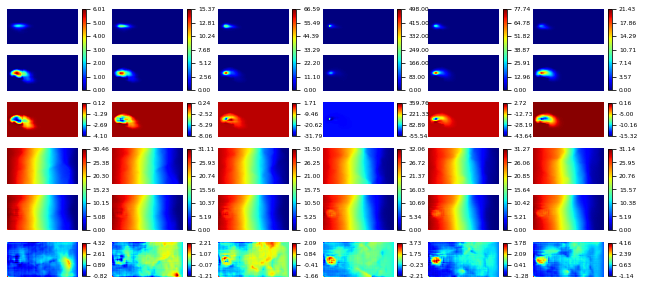

epoch 50, done with printing sample output 70


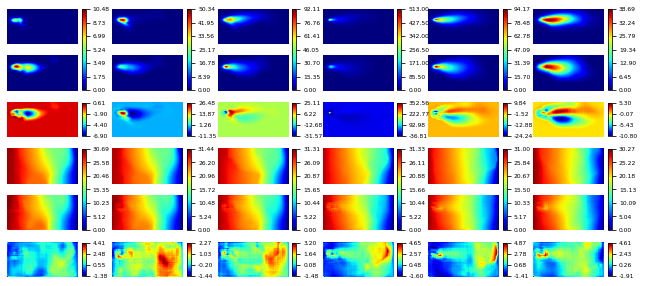

epoch 50, done with printing sample output 440
epoch: 50, test r2-score:  0.8121
epoch: 100, training r2-score: 0.8752
Index of data: tensor([ 31, 411])
X shape: (500, 3, 6, 41, 81)


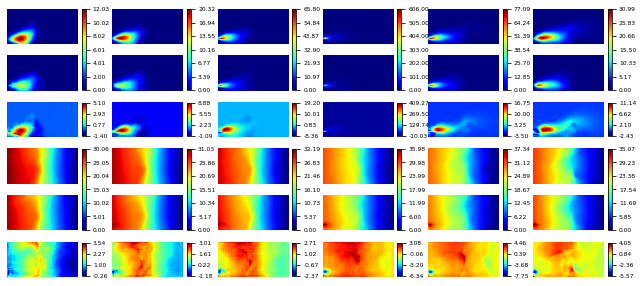

epoch 100, done with printing sample output 31


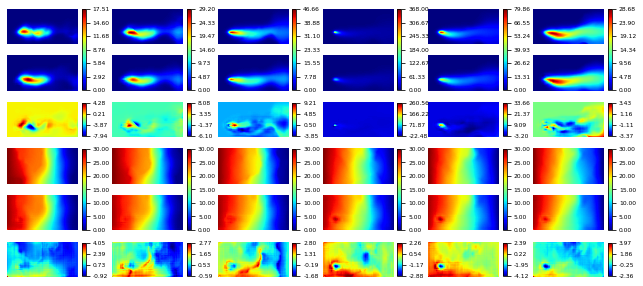

epoch 100, done with printing sample output 411
epoch: 100, test r2-score:  0.8302
Epoch   150: reducing learning rate of group 0 to 8.0000e-03.
epoch: 150, training r2-score: 0.8882
Index of data: tensor([251, 161])
X shape: (500, 3, 6, 41, 81)


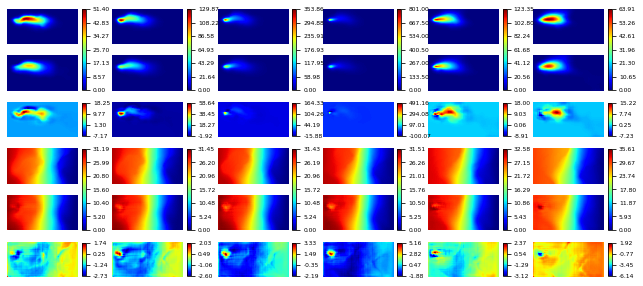

epoch 150, done with printing sample output 251


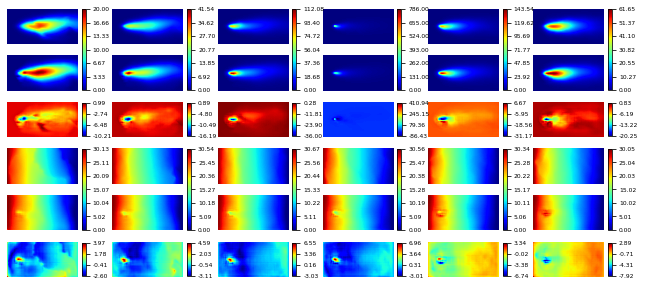

epoch 150, done with printing sample output 161
epoch: 150, test r2-score:  0.8414
epoch: 200, training r2-score: 0.9121
Index of data: tensor([478, 142])
X shape: (500, 3, 6, 41, 81)


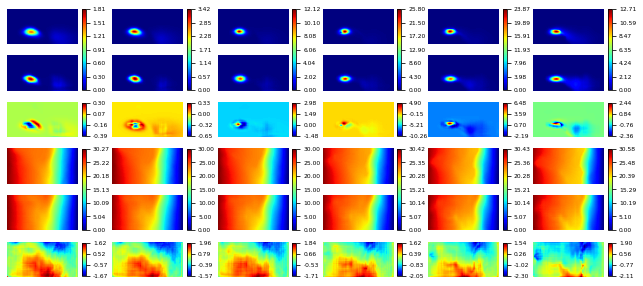

epoch 200, done with printing sample output 478


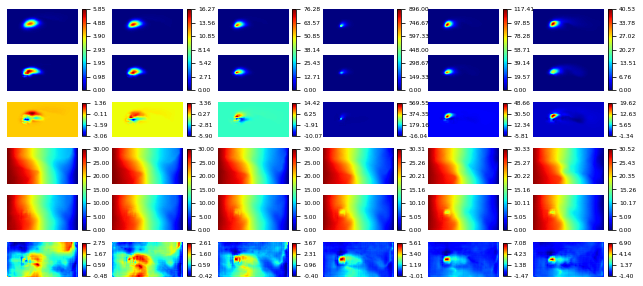

epoch 200, done with printing sample output 142
epoch: 200, test r2-score:  0.8646
Epoch   225: reducing learning rate of group 0 to 6.4000e-03.
epoch: 250, training r2-score: 0.9214
Index of data: tensor([248,  15])
X shape: (500, 3, 6, 41, 81)


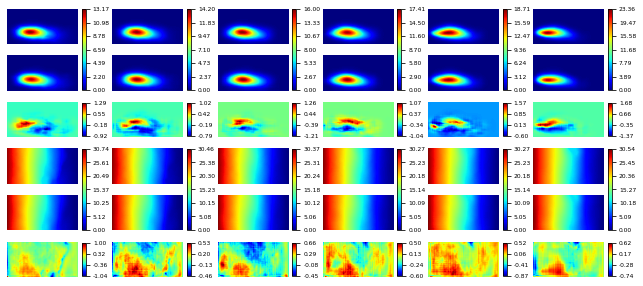

epoch 250, done with printing sample output 248


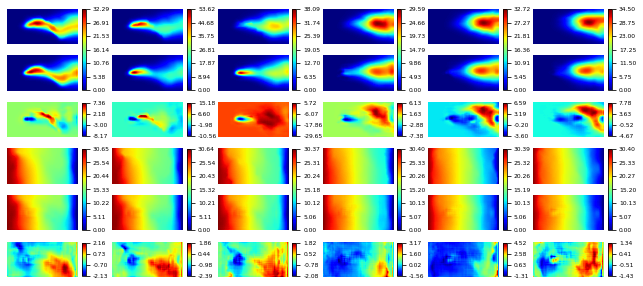

epoch 250, done with printing sample output 15
epoch: 250, test r2-score:  0.8715
epoch: 300, training r2-score: 0.9272
Index of data: tensor([372, 378])
X shape: (500, 3, 6, 41, 81)


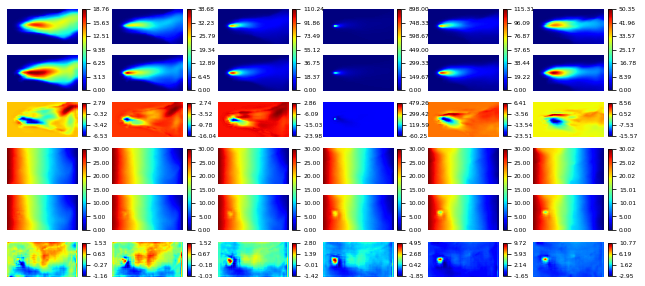

epoch 300, done with printing sample output 372


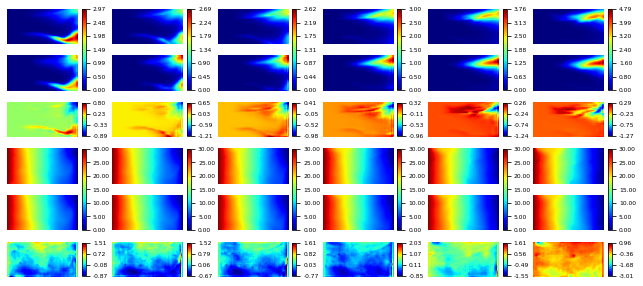

epoch 300, done with printing sample output 378
epoch: 300, test r2-score:  0.8669
Epoch   337: reducing learning rate of group 0 to 5.1200e-03.
epoch: 350, training r2-score: 0.9324
Index of data: tensor([414, 226])
X shape: (500, 3, 6, 41, 81)


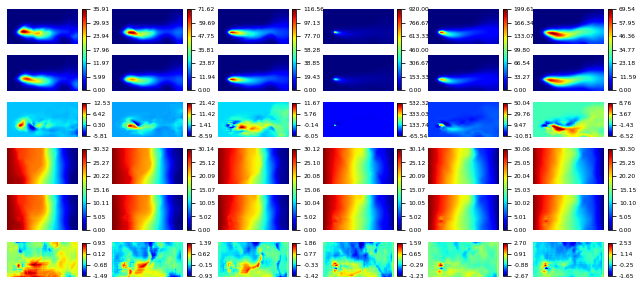

epoch 350, done with printing sample output 414


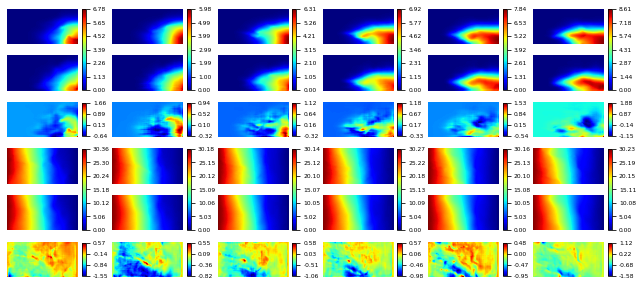

epoch 350, done with printing sample output 226
epoch: 350, test r2-score:  0.8804
epoch: 400, training r2-score: 0.9370
Index of data: tensor([279, 235])
X shape: (500, 3, 6, 41, 81)


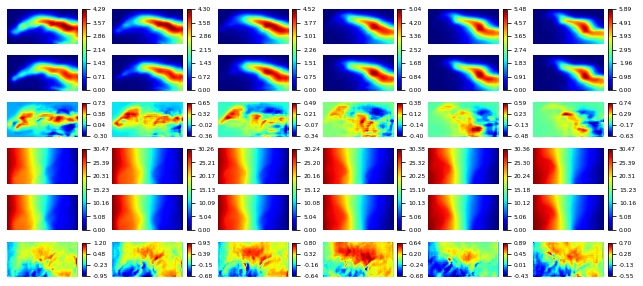

epoch 400, done with printing sample output 279


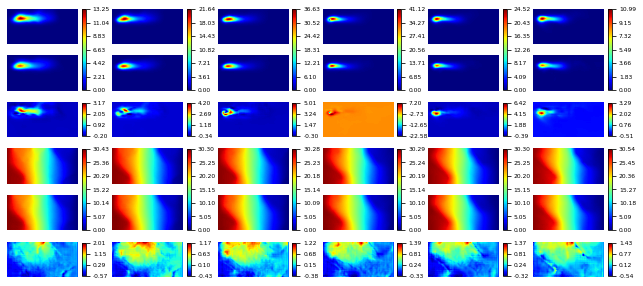

epoch 400, done with printing sample output 235
epoch: 400, test r2-score:  0.8839
Epoch   405: reducing learning rate of group 0 to 4.0960e-03.
epoch: 450, training r2-score: 0.9407
Index of data: tensor([248, 136])
X shape: (500, 3, 6, 41, 81)


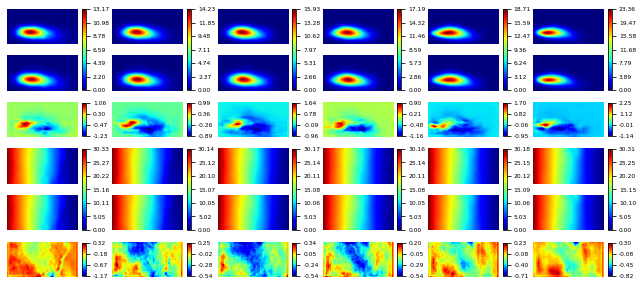

epoch 450, done with printing sample output 248


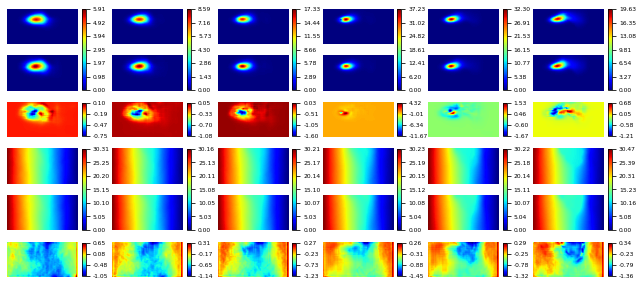

epoch 450, done with printing sample output 136
epoch: 450, test r2-score:  0.8762
Epoch   451: reducing learning rate of group 0 to 3.2768e-03.
epoch: 500, training r2-score: 0.9447
Index of data: tensor([350, 383])
X shape: (500, 3, 6, 41, 81)


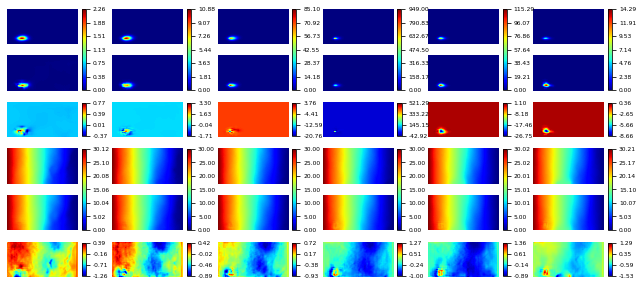

epoch 500, done with printing sample output 350


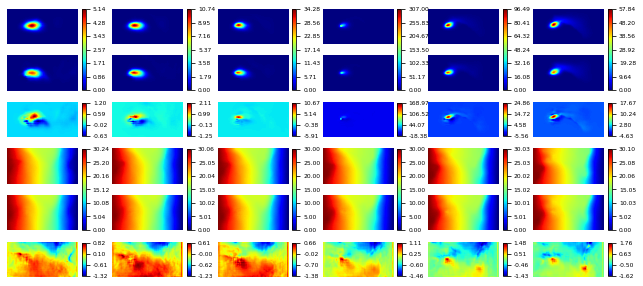

epoch 500, done with printing sample output 383
epoch: 500, test r2-score:  0.8860
Done training 500 epochs with 1000 data using 16695.18004631996 seconds


In [21]:
print("Start training network")
tic = time()
r2_train, r2_test, rmse_train, rmse_test = [], [], [], []
for epoch in range(1, args.n_epochs + 1):
    model.train()
    mse = 0.
    for batch_idx, (input, target) in enumerate(train_loader):
        input, target = input.to(device), target.to(device)
        model.zero_grad()
        output = model(input)
        loss = F.l1_loss(output, target, reduction='sum')
        loss.backward()
        optimizer.step()
        mse += F.mse_loss(output, target, reduction='sum').item()

    rmse = np.sqrt(mse / n_out_pixels_train)
    scheduler.step(rmse)

    if epoch % args.log_interval == 0:
        r2_score = 1 - mse / y_train_var
        print("epoch: {}, training r2-score: {:.4f}".format(epoch, r2_score))
        r2_train.append(r2_score)
        rmse_train.append(rmse)
        r2_t, rmse_t = test(epoch, plot_intv=args.plot_interval)
        r2_test.append(r2_t)
        rmse_test.append(rmse_t)

    # save model
    if epoch == args.n_epochs or epoch%100==0:
        torch.save(model.state_dict(), model_dir + "/model_epoch{}.pth".format(epoch))

tic2 = time()
print("Done training {} epochs with {} data using {} seconds"
      .format(args.n_epochs, args.n_train, tic2 - tic))

# plot the convergence of R2 and RMSE
plot_r2_rmse(r2_train, r2_test, rmse_train, rmse_test, exp_dir, args)

# save args and time taken
args_dict = {}
for arg in vars(args):
    args_dict[arg] = getattr(args, arg)
args_dict['time'] = tic2 - tic
n_params, n_layers = model._num_parameters_convlayers()
args_dict['num_layers'] = n_layers
args_dict['num_params'] = n_params
with open(exp_dir + "/args.txt", 'w') as file:
    file.write(json.dumps(args_dict))

# R2_test_s = cal_R2()
# R2_test_self = []
# R2_test_self.append(R2_test_s)
# np.savetxt(exp_dir + "/R2_test_self.txt", R2_test_self)

## if load trained model

In [11]:
all_over_again = 'Mar_20'

exp_dir = args.data_dir + all_over_again + "/Ntrs{}_Bts{}_Eps{}_wd{}_lr{}_f{}".\
    format(args.n_train,
           args.batch_size, args.n_epochs, args.weight_decay, args.lr, args.filters,)

output_dir = exp_dir + "/predictions"
model_dir = exp_dir

model.load_state_dict(torch.load(model_dir+'/model_epoch'+'{}'.format(args.n_epochs)+'.pth'))

<All keys matched successfully>

# sensor locations, check if the N_obs are correct:

In [ ]:
# np.random.seed(888)
# y_obs = np.linspace(5, 35, num=4)
# x_obs = np.linspace(30, 80, num=5)
# sensor = np.zeros((6, 41, 81))
# for i in range(len(y_obs)):
#     for j in range(6):
#         for k in range(len(x_obs)):
#             sensor[j, int(y_obs[i]), int(x_obs[k])] = 1
# simple_plot(sensor, 'sensor location')
# sensor = sensor>0
# with open('/content/drive/MyDrive/react_inverse/dense_ed_3d/sensor_loc.pkl', 'wb') as file:
#     pk.dump(sensor, file)

# Bayesian NN with SVGD optimization

In [ ]:
def log_sum_exp(input, dim=None, keepdim=False):
    """Numerically stable LogSumExp.

    Args:
        input (Tensor)
        dim (int): Dimension along with the sum is performed
        keepdim (bool): Whether to retain the last dimension on summing

    Returns:
        Equivalent of log(sum(exp(inputs), dim=dim, keepdim=keepdim)).
    """
    # For a 1-D array x (any array along a single dimension),
    # log sum exp(x) = s + log sum exp(x - s)
    # with s = max(x) being a common choice.
    if dim is None:
        input = input.view(-1)
        dim = 0
    max_val = input.max(dim=dim, keepdim=True)[0]
    output = max_val + (input - max_val).exp().sum(dim=dim, keepdim=True).log()
    if not keepdim:
        output = output.squeeze(dim)
    return output


def parameters_to_vector(parameters, grad=False, both=False):
    """Convert parameters or/and their gradients to one vector
    Arguments:
        parameters (Iterable[Variable]): an iterator of Variables that are the
            parameters of a model.
        grad (bool): Vectorizes gradients if true, otherwise vectorizes params
        both (bool): If True, vectorizes both parameters and their gradients,
            `grad` has no effect in this case. Otherwise vectorizes parameters
            or gradients according to `grad`.
    Returns:
        The parameters or/and their gradients (each) represented by a single
        vector (th.Tensor, not Variable)
    """
    # Flag for the device where the parameter is located
    param_device = None

    if not both:
        vec = []
        if not grad:
            for param in parameters:
                # Ensure the parameters are located in the same device
                param_device = _check_param_device(param, param_device)
                vec.append(param.data.view(-1))
        else:
            for param in parameters:
                param_device = _check_param_device(param, param_device)
                vec.append(param.grad.data.view(-1))
        return torch.cat(vec)
    else:
        vec_params, vec_grads = [], []
        for param in parameters:
            param_device = _check_param_device(param, param_device)
            vec_params.append(param.data.view(-1))
            vec_grads.append(param.grad.data.view(-1))
        return torch.cat(vec_params), torch.cat(vec_grads)

def vector_to_parameters(vec, parameters, grad=True):
    """Convert one vector to the parameters or gradients of the parameters
    Arguments:
        vec (torch.Tensor): a single vector represents the parameters of a model.
        parameters (Iterable[Variable]): an iterator of Variables that are the
            parameters of a model.
        grad (bool): True for assigning de-vectorized `vec` to gradients
    """
    # Ensure vec of type Variable
    if not isinstance(vec, torch.cuda.FloatTensor):
        raise TypeError('expected torch.Tensor, but got: {}'
                        .format(torch.typename(vec)))
    # Flag for the device where the parameter is located
    param_device = None

    # Pointer for slicing the vector for each parameter
    pointer = 0
    if grad:
        for param in parameters:
            # Ensure the parameters are located in the same device
            param_device = _check_param_device(param, param_device)
            # The length of the parameter
            num_param = torch.prod(torch.LongTensor(list(param.size())))
            param.grad.data = vec[pointer:pointer + num_param].view(
                param.size())
            # Increment the pointer
            pointer += num_param
    else:
        for param in parameters:
            # Ensure the parameters are located in the same device
            param_device = _check_param_device(param, param_device)
            # The length of the parameter
            num_param = torch.prod(torch.LongTensor(list(param.size())))
            param.data = vec[pointer:pointer + num_param].view(
                param.size())
            # Increment the pointer
            pointer += num_param


def _check_param_device(param, old_param_device):
    """This helper function is to check if the parameters are located
    in the same device. Currently, the conversion between model parameters
    and single vector form is not supported for multiple allocations,
    e.g. parameters in different GPUs, or mixture of CPU/GPU.
    Arguments:
        param ([Variable]): a Variable of a parameter of a model
        old_param_device (int): the device where the first parameter of a
                                model is allocated.
    Returns:
        old_param_device (int): report device for the first time
    """

    # Meet the first parameter
    if old_param_device is None:
        old_param_device = param.get_device() if param.is_cuda else -1
    else:
        warn = False
        if param.is_cuda:  # Check if in same GPU
            warn = (param.get_device() != old_param_device)
        else:  # Check if in CPU
            warn = (old_param_device != -1)
        if warn:
            raise TypeError('Found two parameters on different devices, '
                            'this is currently not supported.')
    return old_param_device


In [ ]:
"""
Particle approximations for posterior of Bayesian neural net used in SVGD.

References:
    Liu, Qiang, and Dilin Wang. "Stein variational gradient descent:
    A general purpose bayesian inference algorithm." NIPS. 2016.

methods:
    __init__
    forward
    compute_loss
    compute_mse_nlp
    predict
    propagate

Note: 
`torch.distributions` is not much used in this implementation to keep simple.
Also we trade computing for memory by using for-loop rather than in a batch way.
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class BayesNN(nn.Module):
    """Class for Bayesian NNs with Stein Variational Gradient Descent.
    Not for usage independently.
    
    Bayesian NNs: y = f(x, w) + n

    uncertain weights:
            w_i ~ Normal(w_i | mu=0, 1 / alpha) 
            alpha ~ Gamma(alpha | shape=1, rate=0.05) (shared)
            --> w_i ~ StudentT(w_i | mu=0, lambda=shape/rate, nu=2*shape)
            Parameterization of StudentT in Bishop p.103 Eq. (2.159)

    Assumptions on noise:
        Additive, Gaussian, homoscedastic (independent of input), 
        output wise (same for every pixels in the output).
            n ~ Normal(0, 1 / beta)
            beta ~ Gamma(beta | shape=2, rate=2e-6)

    Hyperparameters for weights and noise are pre-defined based on heuristic.

    Given a deterministic `model`, initialize `n_samples` replicates
    of the `model`. (plus `n_samples` of noise precision realizations)

    `model` must implement `reset_parameters` method for the replicates
    to have different initial realizations of uncertain parameters.

    References:
        Liu, Qiang, and Dilin Wang. "Stein variational gradient descent:
        A general purpose bayesian inference algorithm."
        Advances In Neural Information Processing Systems. 2016.

    Args:
        model (nn.Module): The deterministic NN to be instantiated `n_samples` 
            times
        data_loader (utils.data.DataLoader): For training and testing
        n_samples (int): Number of samples for uncertain parameters
    """
    def __init__(self, model, n_samples=20):
        super(BayesNN, self).__init__()
        if not isinstance(model, nn.Module):
            raise TypeError("model {} is not a Module subclass".format(
                torch.typename(model)))

        self.n_samples = n_samples

        # w_i ~ StudentT(w_i | mu=0, lambda=shape/rate, nu=2*shape)
        # for efficiency, represent StudentT params using Gamma params
        self.w_prior_shape = 1.
        self.w_prior_rate = 0.05
        
        # noise variance 1e-6: beta ~ Gamma(beta | shape, rate)
        self.beta_prior_shape = 2.
        self.beta_prior_rate = 1.e-6

        # replicate `n_samples` instances with the same network as `model`
        instances = []
        for i in range(n_samples):
            new_instance = copy.deepcopy(model)
            # initialize each model instance with their defualt initialization
            # instead of the prior
            new_instance.reset_parameters()
            print('Reset parameters in model instance {}'.format(i))
            instances.append(new_instance)
        self.nnets = nn.ModuleList(instances)
        del instances

        # log precision (Gamma) of Gaussian noise
        log_beta = Gamma(self.beta_prior_shape, 
                         self.beta_prior_rate).sample((self.n_samples,)).log()
        for i in range(n_samples):
            self.nnets[i].log_beta = Parameter(log_beta[i])

        print('Total number of parameters: {}'.format(self._num_parameters()))

    def _num_parameters(self):
        count = 0
        for name, param in self.named_parameters():
            # print(name)
            count += param.numel()
        return count

    def __getitem__(self, idx):
        return self.nnets[idx]

    @property
    def log_beta(self):
        return torch.tensor([self.nnets[i].log_beta.item() 
            for i in range(self.n_samples)], device=device)

    def forward(self, input):
        """Computes all the `n_samples` NN output
        Args:
            input: N x iC x iH x iW

        Return:
            output: S x N x oC x oH x oW
        """
        output = []
        for i in range(self.n_samples):
            output.append(self.nnets[i].forward(input))
        output = torch.stack(output)

        return output

    def _log_joint(self, index, output, target, ntrain):
        """Log joint probability or unnormalized posterior for single model
        instance. Ignoring constant terms for efficiency.
        Can be implemented in batch computation, but memory is the bottleneck.
        Thus here we trade computation for memory, e.g. using for loop.

        Args:
            index (int): model index, 0, 1, ..., `n_samples`
            output (Tensor): B x oC x oH x oW
            target (Tensor): B x oC x oH x oW
            ntrain (int): total number of training data, mini-batch is used to
                evaluate the log joint prob

        Returns:
            Log joint probability (zero-dim tensor)
        """
        # Normal(target | output, 1 / beta * I)
        log_likelihood = ntrain / output.size(0) * (
                            - 0.5 * self.nnets[index].log_beta.exp()
                            * (target - output).pow(2).sum()
                            + 0.5 * target.numel() * self.nnets[index].log_beta)
        # log prob of prior of weights, i.e. log prob of studentT
        log_prob_prior_w = torch.tensor(0.).to(device)
        for param in self.nnets[index].features.parameters():
            log_prob_prior_w += \
                torch.log1p(0.5 / self.w_prior_rate * param.pow(2)).sum()
        log_prob_prior_w *= -(self.w_prior_shape + 0.5)
        # log prob of prior of log noise-precision (NOT noise precision)
        log_prob_prior_log_beta = ((self.beta_prior_shape-1.0) * self.nnets[index].log_beta \
                    - self.nnets[index].log_beta.exp() * self.beta_prior_rate)
        return log_likelihood + log_prob_prior_w + log_prob_prior_log_beta


    def _compute_mse_nlp(self, input, target, size_average=True, out=False):
        """Evaluate the MSE and Negative Log Probability.

        Args:
            input (Tensor): (N, iC, iH, iW)
            target (Tensor): (N, oC, oH, oW)
            size_average (bool)
            out (bool): If True, return output of `bayes_nn` w. `input`

        Returns:
            (mse, nlp) if `out` is False, o.w. (mse, nlp, output)
            where output is of size (S, N, oC, oH, oW)
        """
        # S x N x oC x oH x oW
        output = self.forward(input)
        # S x 1 x 1 x 1 x 1
        log_beta = self.log_beta.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        log_2pi_S = torch.tensor(0.5 * target[0].numel() * math.log(2 * math.pi)
                       + math.log(self.n_samples), device=device)
        # S x N
        exponent = - 0.5 * (log_beta.exp() * ((target - output) ** 2)).view(
            self.n_samples, target.size(0), -1).sum(-1) \
                   + 0.5 * target[0].numel() * self.log_beta.unsqueeze(-1)

        # n = target[0].numel()
        nlp = - log_sum_exp(exponent, dim=0).mean() + log_2pi_S
        mse = ((target - output.mean(0)) ** 2).mean()

        if not size_average:
            mse *= target.numel()
            nlp *= target.size(0)
        if not out:
            return mse, nlp
        else:
            return mse, nlp, output


    def predict(self, x_test):
        """
        Predictive mean and variance at x_test. (only average over w and beta)
        Args:
            x_test (Tensor): [N, *], test input
        """
        # S x N x oC x oH x oW
        y = self.forward(x_test)
        y_pred_mean = y.mean(0)
        # compute predictive variance per pixel
        # N x oC x oH x oW
        EyyT = (y ** 2).mean(0)
        EyEyT = y_pred_mean ** 2
        beta_inv = (- self.log_beta).exp()
        y_pred_var = beta_inv.mean() + EyyT - EyEyT

        return y_pred_mean, y_pred_var


    def propagate(self, mc_loader):
        """
        Mean and Variance statistics of predictive output distribution
        averaging over the input distribution, i.e. uncertainty propagation.

        First compute the conditional predictive mean and var given realizations
        of uncertain surrogate; then compute the statistics of those conditional
        statistics.

        Args:
            mc_loader (torch.utils.data.DataLoader): dataloader for the Monte 
                Carlo data (10,000 is used in this work)

            S: num of samples
            M: num of data
            D: output dimensions
        """
        # First compute conditional statistics
        # S x N x oC x oH x oW
        # self.cpu()
        # x_test = x_test.cpu()
        # print('here')

        # S x oC x oH x oW
        output_size = mc_loader.dataset[0][1].size()
        cond_Ey = torch.zeros(self.n_samples, *output_size, device=device)
        cond_Eyy = torch.zeros_like(cond_Ey)

        for _, (x_mc, _) in enumerate(mc_loader):
            x_mc = x_mc.to(device)
            # S x B x oC x oH x oW            
            y = self.forward(x_mc)
            cond_Ey += y.mean(1)
            cond_Eyy += y.pow(2).mean(1)
        cond_Ey /= len(mc_loader)
        cond_Eyy /= len(mc_loader)
        beta_inv = (- self.log_beta).exp()
        print('Noise variances: {}'.format(beta_inv))
        
        y_cond_pred_var = cond_Eyy - cond_Ey ** 2 \
                     + beta_inv.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

        # compute statistics of conditional statistics
        return cond_Ey.mean(0), cond_Ey.var(0), \
               y_cond_pred_var.mean(0), y_cond_pred_var.var(0)



In [ ]:



ckpt_freq = args.ckpt_freq
ckpt_dir = args.ckpt_dir


class SVGD(object):
    """Base class for Stein Variational Gradient Descent, with for-loops...
    The Bayesian neural network is defined in `bayes_nn.BayesNN` class.    

    References:
        Liu, Qiang, and Dilin Wang. "Stein variational gradient descent:
        A general purpose bayesian inference algorithm."
        Advances In Neural Information Processing Systems. 2016.

    Args:
        model (nn.Module): The model to be instantiated `n_samples` times
        data_loader (utils.data.DataLoader): For training and testing
        n_samples (int): Number of samples for uncertain parameters
    """

    def __init__(self, bayes_nn, train_loader, args):
        """
        For-loop implementation of SVGD.

        Args:
            bayes_nn (nn.Module): Bayesian NN
            train_loader (utils.data.DataLoader): Training data loader
            logger (dict)

        """
        self.bayes_nn = bayes_nn
        self.train_loader = train_loader
        self.n_samples = args.n_samples
        self.optimizers, self.schedulers = self._optimizers_schedulers(
                                            args.lr, args.lr_noise)


    def _squared_dist(self, X):
        """Computes squared distance between each row of `X`, ||X_i - X_j||^2

        Args:
            X (Tensor): (S, P) where S is number of samples, P is the dim of 
                one sample

        Returns:
            (Tensor) (S, S)
        """
        XXT = torch.mm(X, X.t())
        XTX = XXT.diag()
        return -2.0 * XXT + XTX + XTX.unsqueeze(1)


    def _Kxx_dxKxx(self, X):
        """
        Computes covariance matrix K(X,X) and its gradient w.r.t. X
        for RBF kernel with design matrix X, as in the second term in eqn (8)
        of reference SVGD paper.

        Args:
            X (Tensor): (S, P), design matrix of samples, where S is num of
                samples, P is the dim of each sample which stacks all params
                into a (1, P) row. Thus P could be 1 millions.
        """
        squared_dist = self._squared_dist(X)
        l_square = 0.5 * squared_dist.median() / math.log(self.n_samples)
        Kxx = torch.exp(-0.5 / l_square * squared_dist)
        # matrix form for the second term of optimal functional gradient
        # in eqn (8) of SVGD paper
        dxKxx = (Kxx.sum(1).diag() - Kxx).matmul(X) / l_square

        return Kxx, dxKxx

    
    def _optimizers_schedulers(self, lr, lr_noise):
        """Initialize Adam optimizers and schedulers (ReduceLROnPlateau)

        Args:
            lr (float): learning rate for NN parameters `w`
            lr_noise (float): learning rate for noise precision `log_beta`
        """
        optimizers = []
        schedulers = []
        for i in range(self.n_samples):
            parameters = [{'params': [self.bayes_nn[i].log_beta], 'lr': lr_noise},
                    {'params': self.bayes_nn[i].features.parameters()}]
            optimizer_i = torch.optim.Adam(parameters, lr=lr)
            optimizers.append(optimizer_i)
            schedulers.append(ReduceLROnPlateau(optimizer_i, 
                    mode='min', factor=0.1, patience=10, verbose=True))
        return optimizers, schedulers


    def train(self, epoch, logger):

        self.bayes_nn.train()
        mse = 0.
        for batch_idx, (input, target) in enumerate(self.train_loader):
            input, target = input.to(device), target.to(device)

            self.bayes_nn.zero_grad()
            output = torch.zeros_like(target)
            # all gradients of log joint probability: (S, P)
            grad_log_joint = []
            # all model parameters (particles): (S, P)
            theta = []
            # store the joint probabilities
            log_joint = 0.

            for i in range(self.n_samples):
                output_i = self.bayes_nn[i].forward(input)
                output += output_i.detach()
                log_joint_i = self.bayes_nn._log_joint(i, output_i, target, args.n_train)
                # backward to compute gradients of log joint probabilities
                log_joint_i.backward()
                # monitoring purpose
                log_joint += log_joint_i.item()
                # backward frees memory for computation graph
                # computation below does not build computation graph
                # extract parameters and their gradients out from models
                vec_param, vec_grad_log_joint = parameters_to_vector(
                    self.bayes_nn[i].parameters(), both=True)
                grad_log_joint.append(vec_grad_log_joint.unsqueeze(0))
                theta.append(vec_param.unsqueeze(0))

            # calculating the kernel matrix and its gradients
            theta = torch.cat(theta)
            Kxx, dxKxx = self._Kxx_dxKxx(theta)
            grad_log_joint = torch.cat(grad_log_joint)
            # this line needs S x P memory
            grad_logp = torch.mm(Kxx, grad_log_joint)
            # negate grads here!!!
            grad_theta = - (grad_logp + dxKxx) / self.n_samples
            # explicitly deleting variables does not release memory :(
       
            # update param gradients
            for i in range(self.n_samples):
                vector_to_parameters(grad_theta[i],
                    self.bayes_nn[i].parameters(), grad=True)
                self.optimizers[i].step()
            # WEAK: no loss function to suggest when to stop or
            # approximation performance
            mse += F.mse_loss(output / self.n_samples, target).item()

        # logging
        rmse_train = np.sqrt(mse / len(self.train_loader))
        r2_train = 1 - mse * target.numel()  / logger['train_output_var']
        logger['rmse_train'].append(rmse_train)
        logger['r2_train'].append(r2_train)
        logger['log_beta'].append(self.bayes_nn.log_beta.mean().item())
        print("epoch {}, training r2: {:.6f}".format(epoch, r2_train))

        for i in range(self.n_samples):
            self.schedulers[i].step(rmse_train)

        # save trained models
        if epoch == args.n_epochs or epoch%100==0:
            torch.save(self.bayes_nn.state_dict(), 
                model_dir + "/model_epoch{}.pth".format(epoch))